In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import RidgeClassifier
from sklearn.kernel_approximation import RBFSampler

from sklearn.linear_model import RidgeClassifier

import matplotlib.pyplot as plt

import time

In [2]:
from lightonml.datasets import FashionMNIST

In [3]:
# import os

# os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Loading the data

In [3]:
(train_data, train_labels), (test_data, test_labels) = FashionMNIST()

# train_data = np.load('../datasets/export/fashion_mnist/numpy/train_data_fashion_mnist.npy').astype('uint8')
# test_data = np.load('../datasets/export/fashion_mnist/numpy/test_data_fashion_mnist.npy').astype('uint8')
# train_labels = np.load('../datasets/export/fashion_mnist/numpy/train_targets_fashion_mnist.npy').astype('uint8')
# test_labels = np.load('../datasets/export/fashion_mnist/numpy/test_targets_fashion_mnist.npy').astype('uint8')

# Convert one-hot to integers
# train_labels = np.argmax(train_labels, axis=1)
# test_labels = np.argmax(test_labels, axis=1)

D = train_data[0].reshape(-1).shape[0]

# Flatten the images
train_data = train_data.reshape(-1, D)
test_data = test_data.reshape(-1, D)

In [4]:
def threshold_binarize(data, threshold):
    data_bin = np.where(data>threshold, 1, 0).astype('uint8')
    return data_bin

In [5]:
# fashion mnist has values between 0 and 255
threshold = 10

train_data_bin = threshold_binarize(train_data, threshold)
test_data_bin = threshold_binarize(test_data, threshold)

## OPU Projection

In [6]:
from lightonml.projections.sklearn import OPUMap

In [2]:
?? OPUMap

In [4]:
?? OPU

In [7]:
n_components = 1000 # number of random projections
random_mapping = OPUMap(n_components=n_components, ndims=1)

In [7]:
dir(random_mapping.opu)

['_OPU__check_booking',
 '_OPU__opu_config',
 '_OPU__transform',
 '_TransformSetup',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_allowed_roi',
 '_cam_roi',
 '_count_ones',
 '_dmd_roi',
 '_max_n_features',
 '_min_batch_size',
 '_min_components',
 '_n_components',
 '_n_count',
 '_n_samples_by_pass',
 '_print',
 '_projection_times',
 '_resize_rnd_matrix',
 'batch_transform',
 'close',
 'device',
 'dmd_strategy',
 'features_fmt',
 'is_simulated',
 'max_n_components',
 'max_n_features',
 'n_components',
 'n_samples_by_pass',
 'open',
 'transform',
 'transform1d',
 'transform2d',
 'verbose',
 'version']

In [8]:
random_mapping.opu._max_n_features

1039680

In [10]:
random_mapping.opu._cam_roi.allowed_roi

[[960, 0], [960, 1080]]

In [16]:
random_mapping.opu.device.exposure_us

400

In [17]:
random_mapping.opu.device.frametime_us

500

In [18]:
random_mapping.opu.device.cam_ROI

([1270, 348], [341, 384])

In [15]:
dir(random_mapping.opu.device)

['_OpuDevice__opu',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cam_ROI_off',
 '_cam_roi_increment',
 '_cam_shape_max',
 '_cam_strategy',
 '_exposure_us_off',
 '_frametime_us_off',
 '_gain_dB_off',
 '_reserved_off',
 '_sequence_nb_prelim',
 'acquire_seq',
 'acquiring',
 'active',
 'cam_ROI',
 'cam_readout_us',
 'cam_roi_increment',
 'cam_roi_strategy',
 'cam_shape',
 'cam_shape_max',
 'close',
 'dmd_shape',
 'exposure_us',
 'fill_dmd',
 'frametime_us',
 'gain_dB',
 'input_size',
 'nb_features',
 'open',
 'opu_type',
 'reserve',
 'transform1',
 'transform2',
 'transform_single',
 'verbose',
 'versions']

## Good exp distribution

In [21]:
class OPUModuleNumpy(object):
    def __init__(self, input_features, output_features, activation=None, bias=False, initial_log_scale='auto', dtype='float32'):
        super(OPUModuleNumpy, self).__init__()
        
        self.real_matrix = np.random.normal(loc=0.0, scale=np.sqrt(0.5), size=(input_features, output_features)).astype(dtype)
        self.img_matrix = np.random.normal(loc=0.0, scale=np.sqrt(0.5), size=(input_features, output_features)).astype(dtype)
        
        if bias:
            self.bias = np.random.uniform(low=0.0, high=2 * np.pi, size=(1, output_features))
        else:
            self.bias = None
            
        self.activation = activation
        
        if initial_log_scale == 'auto':
            self.log_scale = -0.5 * np.log(input_features)
        else:
            self.log_scale = initial_log_scale
        
    def project(self, data, matrix):
        return np.dot(data, matrix)
        
    def forward(self, data):
        out_real = self.project(data, self.real_matrix) ** 2
        out_img = self.project(data, self.img_matrix) ** 2
        
        output = (out_real + out_img)
        if self.bias is not None:
            output += self.bias
        if self.activation is not None:
            output = self.activation(output)

        return np.exp(self.log_scale) * output

In [22]:
opm = OPUModuleNumpy(784, 10000)

In [23]:
np_projection = opm.forward(np.vstack([train_data_bin, test_data_bin]))

(array([919., 842., 776., 698., 712., 635., 546., 480., 444., 349., 353.,
        332., 304., 238., 212., 228., 183., 162., 139., 155., 138., 103.,
        105.,  97.,  68.,  71.,  70.,  68.,  53.,  58.,  45.,  35.,  31.,
         32.,  33.,  31.,  27.,  10.,  26.,  21.,  18.,  16.,   6.,   8.,
         10.,   9.,   8.,  13.,  11.,   9.,   6.,   6.,   7.,   7.,   3.,
          4.,   1.,   0.,   2.,   3.,   3.,   4.,   3.,   1.,   1.,   1.,
          2.,   1.,   1.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([3.7400962e-06, 1.0003703e-02, 2.0003665e-02, 3.0003628e-02,
        4.0003590e-02, 5.0003555e-02, 6.0003515e-02, 7.0003480e-02,
        8.0003440e-02, 9.0003401e-02, 1.0000337e-01, 1.1000333e-01,
        1.2000329e-01, 1.3000326e-01, 1.4000322e-01, 1.5000318e-01,
        1.6000314e-01, 1.7000310e-01, 1.800030

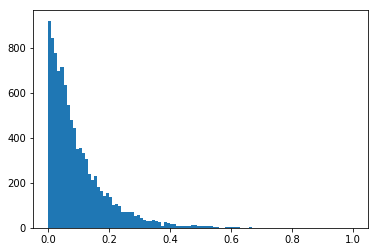

In [36]:
plt.hist(np_projection[1] / np.max(np_projection[1]), bins=100)

In [37]:
a = 1 if 1 == 1 else 0

In [38]:
a

1

In [45]:
import itertools

a=[1,2,3]
b=['a', 'b', 'c']
# c=[]

list(itertools.product(a, b))

[(1, 'a'),
 (1, 'b'),
 (1, 'c'),
 (2, 'a'),
 (2, 'b'),
 (2, 'c'),
 (3, 'a'),
 (3, 'b'),
 (3, 'c')]

(array([145., 445., 953., 553., 884., 543., 770., 455., 889.,  95., 511.,
        282., 308., 329., 202., 315., 127., 203., 144., 207., 131., 186.,
         65., 141.,  72.,  82., 104.,  55.,  94.,  53.,  67.,  43.,  51.,
         43.,  54.,  12.,  36.,  19.,  22.,  30.,  16.,  29.,  21.,  20.,
         11.,  18.,  12.,  17.,   1.,  12.,  14.,   6.,   7.,   6.,   6.,
          7.,   2.,   4.,   6.,   3.,   5.,   4.,   4.,   6.,   1.,   5.,
          3.,   3.,   1.,   3.,   2.,   2.,   1.,   3.,   0.,   2.,   2.,
          1.,   2.,   0.,   3.,   1.,   1.,   3.,   0.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.03529412, 0.04494118, 0.05458824, 0.06423529, 0.07388235,
        0.08352941, 0.09317647, 0.10282353, 0.11247059, 0.12211765,
        0.13176471, 0.14141176, 0.15105882, 0.16070588, 0.17035294,
        0.18      , 0.18964706, 0.19929412, 0.20894118, 0.21858824,
        0.22823529, 0.23788235, 0.24752941, 0.

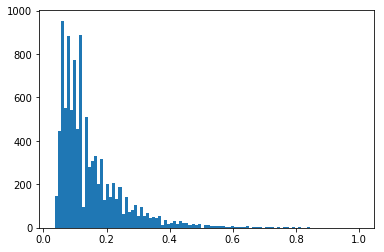

In [35]:
plt.hist(train_random_features[1] / np.max(train_random_features[1]), bins=100)

In [12]:
random_mapping.opu._dmd_roi.dmd_shape

array([ 912, 1140])

In [ ]:
random_mapping.opu.device.cam_roi_increment

In [31]:
random_mapping.opu.device.exposure_us = 400
random_mapping.opu.device.frametime_us = 500

In [8]:
random_mapping.opu.device.cam_shape

[341, 384]

In [1]:
random_mapping.opu.close()

NameError: name 'random_mapping' is not defined

In [ ]:
train_random_features = random_mapping.transform(train_data_bin)
test_random_features = random_mapping.transform(test_data_bin)

In [39]:
np.save('opu_fashion_mnist_features/train_{}K.npy'.format(n_components//1000), train_random_features)

In [40]:
np.save('opu_fashion_mnist_features/test_{}K.npy'.format(n_components//1000), test_random_features)

In [47]:
np.hstack([np.array([1,2,3,4]).reshape((-1, 1)), np.array([1,2,3,4]).reshape((-1, 1))])

array([[1, 1],
       [2, 2],
       [3, 3],
       [4, 4]])

## Ridge Classifier

In [28]:
# OPU: dim=1K, std_dev=0.5, 32bits
since = time.time()

clf = RidgeClassifier(alpha=1.0)
clf.fit(train_random_features, train_labels)
score = clf.score(test_random_features, test_labels)

elapsed = time.time() - since

print('Score:', score)
print('Time:', elapsed)

Score: 0.8444
Time: 0.8923864364624023


In [11]:
# OPU: dim=10K, std_dev=0.5, 32bits
since = time.time()

clf = RidgeClassifier(alpha=1.0)
clf.fit(train_random_features, train_labels)
score = clf.score(test_random_features, test_labels)

elapsed = time.time() - since

print('Score:', score)
print('Time:', elapsed)

Score: 0.8773
Time: 35.18646216392517


In [41]:
# OPU: dim=20K, std_dev=0.5, 32bits
since = time.time()

clf = RidgeClassifier(alpha=1.0)
clf.fit(train_random_features, train_labels)
score = clf.score(test_random_features, test_labels)

elapsed = time.time() - since

print('Score:', score)
print('Time:', elapsed)

Score: 0.8671
Time: 130.62805652618408
